# Review
Hi, my name is <strike>Dmitry</strike> Anton and I will be reviewing your project.

You can find my comments in colored markdown cells:

<div class="alert alert-success">
    If everything is done succesfully.
</div>

<div class="alert alert-warning">
    If I have some (optional) suggestions, or questions to think about, or general comments.
</div>

<div class="alert alert-danger">
    If a section requires some corrections. Work can't be accepted with red comments.
</div>

Please don't remove my comments, as it will make further review iterations much harder for me.

Feel free to reply to my comments or ask questions using the following template:

<div class="alert alert-info">
    For your comments and questions.
</div>

First of all, thank you for turning in the project! You did a great job! Very impressive work. Based on the ROC-AUC of your best model, you got 6 SP. Congratulations!

<div class="alert alert-success">
    <b>Anton's comments: </b> as Dmitry insisted not to delete your comments :) mine will look like this
</div>


# Main Assignment Conditions

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

### Data

[final_provider.zip](Main%20Assignment%20Conditions%203d5f3ce6652547f7827e0a02fd32d44d/final_provider.zip)

The data is also located on the platform in the `/datasets/final_provider/` folder.

# Plan

1. Load data
2. EDA, fill missing data, analysis
3. type conversion, preprocessing
4. building models
5. training, optimization, selecting model
6. Summary

In [ ]:
%%capture
%%bash

pip install catboost
pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import glob
import os

%matplotlib inline
import matplotlib.pyplot as plt

import random
random_state=42
random.seed(random_state)
np.random.seed(random_state)

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import seaborn as sns

In [2]:
import statsmodels as sm
from scipy import stats
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.tree import *
from catboost import CatBoostClassifier, Pool, cv as catboost_cv
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# 1. Load data

%%capture
%%bash

gdown https://drive.google.com/uc?id=1lGScf7dNFmelCLuNWfLIbc2NdQUkHe4L
unzip final_provider.zip -d ./datasets/

In [3]:
os.chdir('final_provider/')

In [4]:
glob.glob("*.csv")

['contract.csv', 'internet.csv', 'personal.csv', 'phone.csv']

In [5]:
dfs = dict(map(lambda f:(os.path.basename(f).replace(".csv", ""),pd.read_csv(f)), glob.glob("*.csv")))

# 2. EDA, fill missing data, analysis

In [6]:
dfs["internet"].head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [7]:
for name, ds in dfs.items():
    print(f"{name} {ds.shape}")

contract (7043, 8)
internet (5517, 8)
personal (7043, 5)
phone (6361, 2)


In [8]:
for name, ds in dfs.items():
    print(f"{name}".upper())
    ds.info()
    print("-"*50)

CONTRACT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
--------------------------------------------------
INTERNET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   Online

In [9]:
for name, ds in dfs.items():
    print(f"{name}".upper())
    display(ds.sample(2))

CONTRACT


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
185,1024-GUALD,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,24.80,24.8
2715,0484-JPBRU,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45


INTERNET


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
811,3748-FVMZZ,DSL,No,No,No,Yes,No,Yes
2065,5028-GZLDO,Fiber optic,No,No,No,No,No,No


PERSONAL


,customerID,gender,SeniorCitizen,Partner,Dependents
451,5760-WRAHC,Female,1,No,No
5087,8739-QOTTN,Female,0,Yes,No


PHONE


,customerID,MultipleLines
2981,1085-LDWAM,No
5471,6595-YGXIT,Yes


In [10]:
def missing_values(df):
  df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
  df_nulls.columns = ["type","count","missing_ratio"]
  df_nulls=df_nulls[df_nulls["count"]>0]
  df_nulls.sort_values(by="missing_ratio", ascending=False)
  return df_nulls

In [11]:
def describe_full(df):
    data_describe = df.describe().T
    df_numeric=df._get_numeric_data()
    dtype_df=df_numeric.dtypes
    data_describe['dtypes']=dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %']=data_null
    Cardinality=df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality']=Cardinality
    df_skew=df_numeric.skew(axis = 0, skipna = True) 
    data_describe['Skew']=df_skew
    return data_describe

In [12]:
def display_group_density_plot(df, groupby, on, palette = None, figsize = None, title="", ax=None): 
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """
    if palette is None:
      palette = sns.color_palette('Set2')
    if figsize is None:
      figsize = (10, 5)
    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    if ax is None:
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
    
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value, ax=ax)
    if not title:
      title = str("Distribution of " + on + " per " + groupby + " group")
    
    ax.set_title(title,fontsize=16)
    ax.set_xlabel(on, fontsize=16)
    return ax 

In [13]:
for name, ds in dfs.items():
  print(50*"-"+name.upper()+50*"-")
  display(describe_full(ds))
  print("\n\n")

--------------------------------------------------CONTRACT--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75,float64,0.0,1585,-0.220524





--------------------------------------------------INTERNET--------------------------------------------------


,count,unique,top,freq,dtypes,Missing %,Cardinality,Skew
customerID,5517,5517,5781-BKHOP,1,NaN,NaN,NaN,NaN
InternetService,5517,2,Fiber optic,3096,NaN,NaN,NaN,NaN
OnlineSecurity,5517,2,No,3498,NaN,NaN,NaN,NaN
OnlineBackup,5517,2,No,3088,NaN,NaN,NaN,NaN
DeviceProtection,5517,2,No,3095,NaN,NaN,NaN,NaN
TechSupport,5517,2,No,3473,NaN,NaN,NaN,NaN
StreamingTV,5517,2,No,2810,NaN,NaN,NaN,NaN
StreamingMovies,5517,2,No,2785,NaN,NaN,NaN,NaN





--------------------------------------------------PERSONAL--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0,int64,0.0,2,1.833633





--------------------------------------------------PHONE--------------------------------------------------


,count,unique,top,freq,dtypes,Missing %,Cardinality,Skew
customerID,6361,6361,8404-VLQFB,1,NaN,NaN,NaN,NaN
MultipleLines,6361,2,No,3390,NaN,NaN,NaN,NaN


let's build one dataframe. I checked that all datasets have one2one connection (at least on current datasets)

In [14]:
df = (dfs["personal"]
   .merge(dfs["contract"], how="left", on="customerID")
   .merge(dfs["phone"], how="left", on="customerID")
   .merge(dfs["internet"], how="left", on="customerID"))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


In [16]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No


in my opinion, missing data about internet services, because those clients don't have internet service at all(only phone) and let's fill it by "No" value

In [17]:
for col in ["OnlineSecurity",	"OnlineBackup",	"DeviceProtection",	"TechSupport",	"StreamingTV",	"StreamingMovies"]:
  df[col] = df[col].fillna("No")

In [18]:
df["MultipleLines"] = df["MultipleLines"].fillna("No")

In [19]:
df["InternetService"] = df["InternetService"].fillna("No Service")

# 3. EDA, type conversion, preprocessing

In [20]:
for col in df.select_dtypes("object").columns:
  if sorted(df[col].unique())==["No","Yes"]:
    df[col] = (df[col] == "Yes").astype("int")

In [21]:
df["gender"] = (df["gender"] == "Male").astype("int")

In [22]:
df[df["TotalCharges"]==" "]

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
488,4472-LVYGI,0,0,1,1,2020-02-01,No,Two year,1,Bank transfer (automatic),52.55,,0,DSL,1,0,1,1,1,0
753,3115-CZMZD,1,0,0,1,2020-02-01,No,Two year,0,Mailed check,20.25,,0,No Service,0,0,0,0,0,0
936,5709-LVOEQ,0,0,1,1,2020-02-01,No,Two year,0,Mailed check,80.85,,0,DSL,1,1,1,0,1,1
1082,4367-NUYAO,1,0,1,1,2020-02-01,No,Two year,0,Mailed check,25.75,,1,No Service,0,0,0,0,0,0
1340,1371-DWPAZ,0,0,1,1,2020-02-01,No,Two year,0,Credit card (automatic),56.05,,0,DSL,1,1,1,1,1,0
3331,7644-OMVMY,1,0,1,1,2020-02-01,No,Two year,0,Mailed check,19.85,,0,No Service,0,0,0,0,0,0
3826,3213-VVOLG,1,0,1,1,2020-02-01,No,Two year,0,Mailed check,25.35,,1,No Service,0,0,0,0,0,0
4380,2520-SGTTA,0,0,1,1,2020-02-01,No,Two year,0,Mailed check,20.00,,0,No Service,0,0,0,0,0,0
5218,2923-ARZLG,1,0,1,1,2020-02-01,No,One year,1,Mailed check,19.70,,0,No Service,0,0,0,0,0,0
6670,4075-WKNIU,0,0,1,1,2020-02-01,No,Two year,0,Mailed check,73.35,,1,DSL,0,1,1,1,1,0


it seems that date of the gathering data is less then 2020-03-01, we have empty TotalCharges for clients who has BeginDate > 2020-02-01

In [23]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0.0)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int32  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int32  
 4   Dependents        7043 non-null   int32  
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   int32  
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   float64
 12  MultipleLines     7043 non-null   int32  
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   int32  
 15  OnlineBackup      7043 non-null   int32  
 16  DeviceProtection  7043 non-null   int32  


In [25]:
df["churn"] = (df["EndDate"]!="No").astype("int")

In [26]:
df_final = df.drop(["BeginDate",	"EndDate"], axis=1)

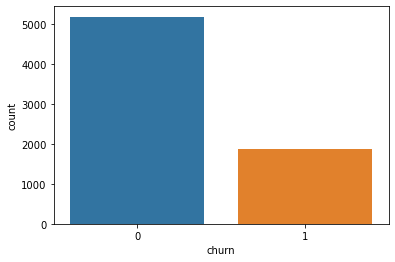

In [27]:
sns.countplot(df_final["churn"])

as we see dataset is a bit imbalanced, but not so much

In [28]:
if "customerID" in df_final.columns:
  df_final = df_final.drop("customerID", axis=1)
categories = ["Type", "PaymentMethod", "InternetService", "gender", "SeniorCitizen",	"Partner",	"Dependents", "PaperlessBilling", "MultipleLines", \
              "OnlineSecurity",	"OnlineBackup",	"DeviceProtection",	"TechSupport",	"StreamingTV",	"StreamingMovies" ]
target = "churn"
features = list(set(df_final.columns) - set([target]))

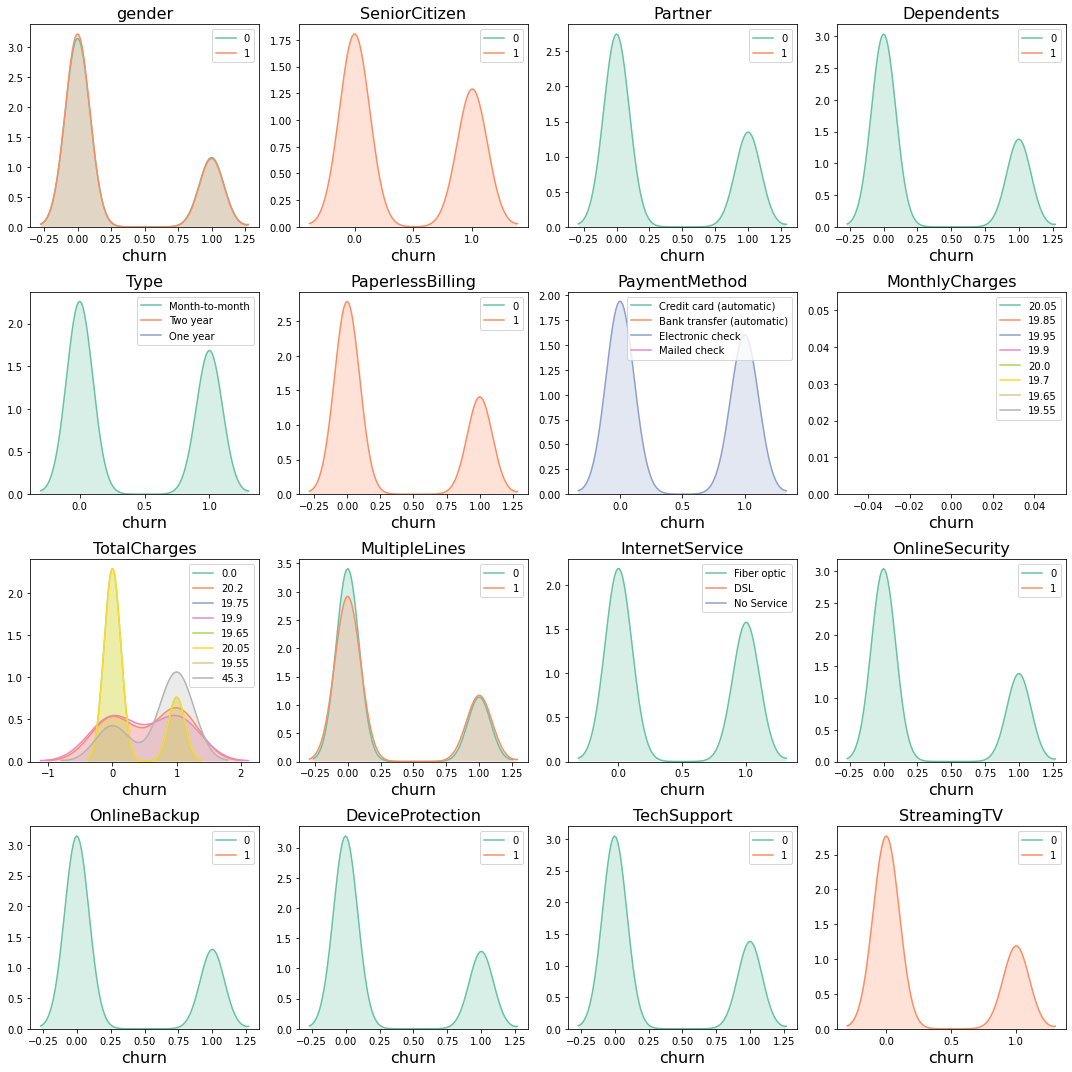

In [29]:
fig, axs = plt.subplots(4, len(df_final.columns) // 4, figsize=(15,15))
axs = axs.flatten()

for cat_col, ax in zip(df_final.columns, axs):
    display_group_density_plot(df_final, groupby = cat_col, on = target, \
                                           palette = sns.color_palette('Set2'), 
                                title=cat_col,
                           figsize = (10, 5), ax=ax)
    ax.legend()


plt.tight_layout()
plt.show()

as we could see, interesting plots are for Type and Total Charges. we could assume by density that recent clients(month-to-month) with high charges have tendency to churn  

let's analyze densities by charges

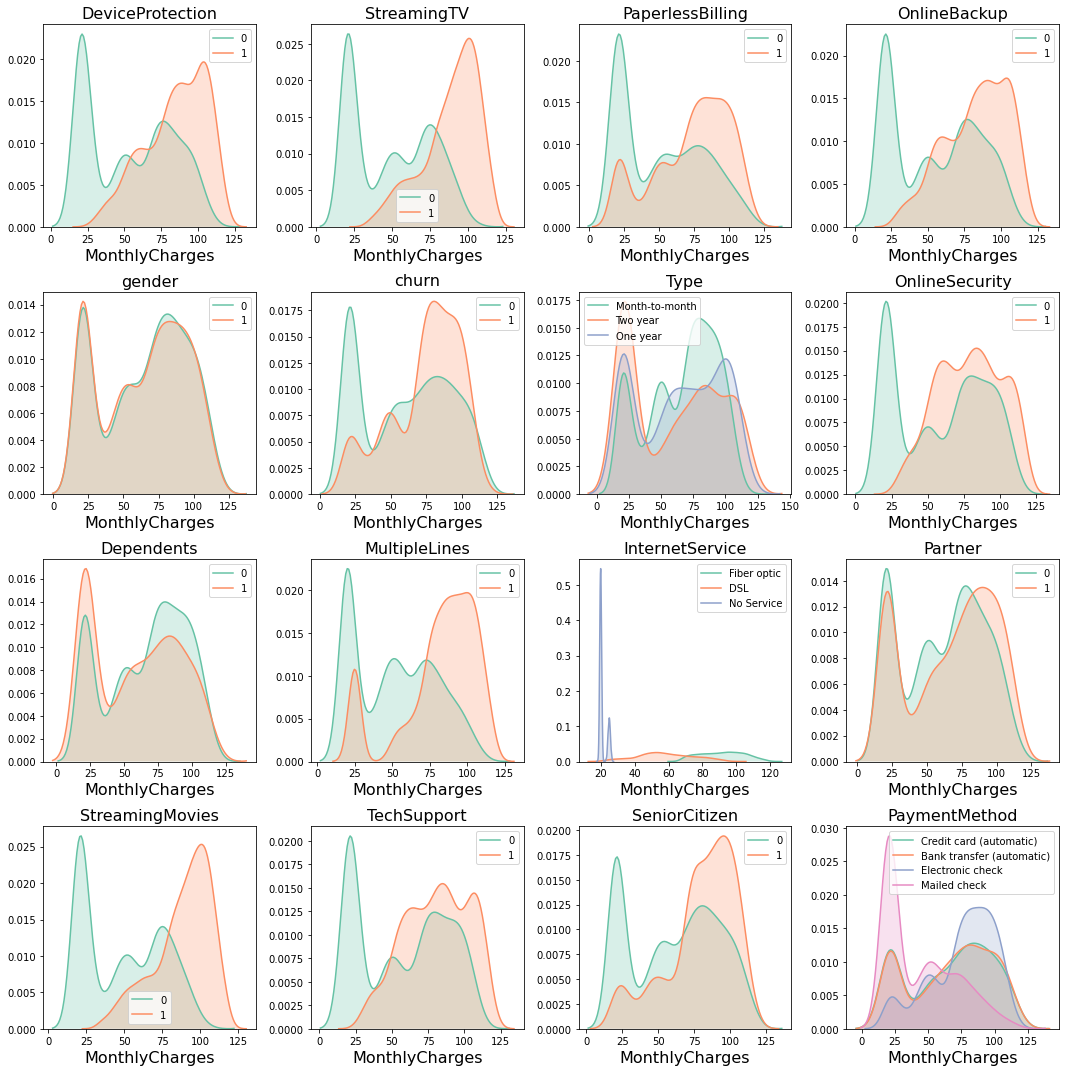

In [30]:
cols = list(set(df_final.columns) - set(["MonthlyCharges", "TotalCharges"]))
fig, axs = plt.subplots(4, len(cols) // 4, figsize=(15,15))
axs = axs.flatten()

for cat_col, ax in zip(cols, axs):
    display_group_density_plot(df_final, groupby = cat_col, on = "MonthlyCharges", \
                                           palette = sns.color_palette('Set2'), 
                                title=cat_col,
                           figsize = (10, 5), ax=ax)
    ax.legend()


plt.tight_layout()
plt.show()

charges related with type of the payment and it seems indeed that month-to-month clients have high charges 

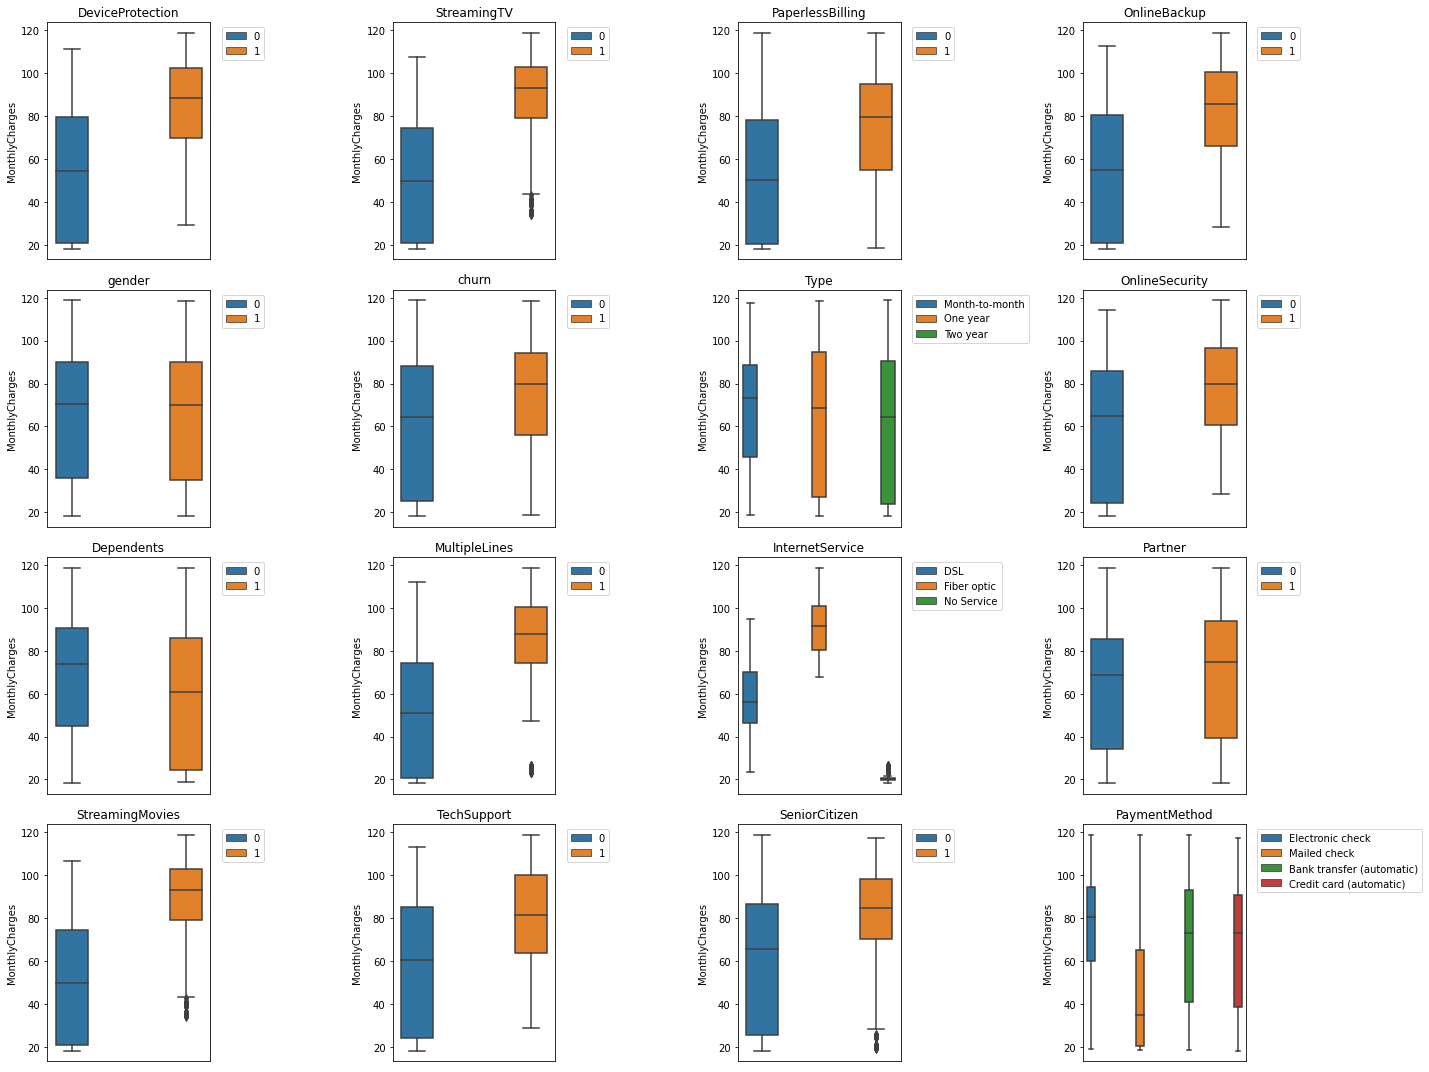

In [31]:
cols = list(set(df_final.columns) - set(["MonthlyCharges", "TotalCharges"]))
fig, axs = plt.subplots(4, len(cols) // 4, figsize=(20,15))
axs = axs.flatten()

for cat_col, ax in zip(cols, axs):
    sns.boxplot(x=cat_col, y="MonthlyCharges", hue=cat_col, data=df_final, ax=ax)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_title(cat_col)


plt.tight_layout()
plt.show()

In [32]:
corr_df = df_final.corr()
corr_df.iloc[corr_df['churn'].abs().argsort()]["churn"]

gender             -0.008612
MultipleLines       0.040102
StreamingMovies     0.061382
StreamingTV         0.063228
DeviceProtection   -0.066160
OnlineBackup       -0.082255
Partner            -0.150448
SeniorCitizen       0.150889
Dependents         -0.164221
TechSupport        -0.164674
OnlineSecurity     -0.171226
PaperlessBilling    0.191825
MonthlyCharges      0.193356
TotalCharges       -0.198324
churn               1.000000
Name: churn, dtype: float64

and let's check most important features according by catboost classifier

In [33]:
X, y = df_final[features], df_final[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
train_ds = Pool(data=X_train, label=y_train, cat_features=categories, feature_names=features)
test_ds = Pool(data=X_test, label=y_test, cat_features=categories, feature_names=features)
full_ds = Pool(data=X, label=y, cat_features=categories, feature_names=features)
scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
cb = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight, random_seed=random_state,task_type="GPU", devices='0:1').fit(train_ds)
df_feature_importances = pd.DataFrame(((zip(cb.feature_names_, cb.get_feature_importance())))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])

CatBoostError: c:/program files (x86)/go agent/pipelines/buildmaster/catboost.git/catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

At the summary to the plan we can conclude that clients with high month charges (greater than 70) and not high total charges (that's why signs of corr are different) have tendency to leave service, that interested into internet services with electronic payment

On the next step we need build models and find optimal one for ours metric

# Models

<section class="theory-viewer"><section meta="" class="theory-viewer__blocking-layout-block theory-viewer__block theory-viewer__block_type_vertical-layout theory-viewer__block_layout"><section meta="" class="theory-viewer__block theory-viewer__block_type_markdown"><div class="base-markdown base-markdown_with-gallery markdown markdown_size_normal markdown_type_theory"><h1>Solution Code</h1><div class="paragraph">Upload the code of your solution.</div><div class="paragraph">Here are some of the criteria used by the project reviewers:</div><ul><li>Have you performed all the steps?</li><li>Does the solution match the task condition?</li><li>Have you trained and tested the model correctly?</li><li>What is the quality score of the best model?</li><li>Have you kept to the project structure?</li><li>Have you kept the code neat?</li></ul></div></section></section></section>

In [35]:
###helpers functions

def display_classification_report(y_true, y_pred):
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T)

def plot_roc(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        if not ax: fig, ax = plt.subplots(1, 1)
        fpr, tpr, thresholds = roc_curve(y_test, preds)
        ax.plot([0, 1], [0, 1],'r--')
        ax.plot(fpr, tpr, lw=2, label=label)
        ax.legend(loc='lower right')
        ax.set_title(
             'ROC curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(fpr, tpr):.2}')
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.annotate(f'AUC: {auc(fpr, tpr):.2}', xy=(.43, .025))
        ax.legend()
        ax.grid()
        return ax
    

def plot_pr(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        if not ax: fig, ax = plt.subplots()
        ax.plot([0, 1], [1, 0],'r--')    
        ax.plot(recall, precision, lw=2, label=label)
        ax.legend()
        ax.set_title(
            'Precision-recall curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(recall, precision):.2}'
        )
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.legend()
        ax.grid()
        return ax

from previous research we found out that recent clients have tendency to leave service by some reasons. let's create feature of how many days clients use service

In [36]:
from functools import lru_cache
from sklearn.preprocessing import StandardScaler

@lru_cache(1)
def get_data(path=".", oversampling=True, apply_dummies=False):
  target = "churn"

  dfs = dict(map(lambda f:(os.path.basename(f).replace(".csv", ""),pd.read_csv(f)), glob.glob(path+"/*.csv")))
  df = (dfs["personal"]
    .merge(dfs["contract"], how="left", on="customerID")
    .merge(dfs["phone"], how="left", on="customerID")
    .merge(dfs["internet"], how="left", on="customerID"))

  for col in ["OnlineSecurity",	"OnlineBackup",	"DeviceProtection",	"TechSupport",	"StreamingTV",	"StreamingMovies"]:
    df[col] = df[col].fillna("No")
    
  df["MultipleLines"] = df["MultipleLines"].fillna("No")
  df["InternetService"] = df["InternetService"].fillna("No Service")
  for col in df.select_dtypes("object").columns:
    if sorted(df[col].unique())==["No","Yes"]:
      df[col] = (df[col] == "Yes").astype("int")
  df["gender"] = (df["gender"] == "Male").astype("int")
  df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0.0)
  df[target] = (df["EndDate"]!="No").astype("int")
  df.loc[df['EndDate'] == 'No',  'EndDate'] = pd.to_datetime('2020-02-01 00:00:00')
  df["days"] =  (pd.to_datetime(df['EndDate']) - pd.to_datetime(df['BeginDate'])).dt.days
  df = df.drop(["BeginDate", "EndDate"], axis=1)
  
  if "customerID" in df.columns:
    df = df.drop("customerID", axis=1)

  categories = ["Type", "PaymentMethod", "InternetService", "gender", "SeniorCitizen",	"Partner",	"Dependents", "PaperlessBilling", "MultipleLines", \
              "OnlineSecurity",	"OnlineBackup",	"DeviceProtection",	"TechSupport",	"StreamingTV",	"StreamingMovies" ]
  

  features = list(set(df.columns) - set([target]))
  
  if oversampling:
    scale=(1-df[target].values).sum()/df[target].values.sum()
    sample = df[df[target]==1].copy()
    n_sample = int(np.floor(len(sample)*scale)) - len(sample)
    df = pd.concat([sample, sample.sample(n_sample, replace=True), df[df[target]==0].copy()], axis=0).reset_index()
    df = shuffle(df)
  
  X, y = df[features], df[target]
  if apply_dummies:
    remains_cols = list(set(features) - set(categories))
    X = pd.get_dummies(X, drop_first=True)
    features = list(X.columns)
    categories = list(set(features) - set(remains_cols))
    

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
  
  numeric_cols = ["TotalCharges", "MonthlyCharges", "days"]
  scaler = StandardScaler()
  scaler.fit(X_train[numeric_cols])
  X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
  X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
  
  return X_train, X_test, y_train, y_test, features, target, categories
  

<div class="alert alert-success">
    Good job on data preprocessing! The dataframes were merged correctly, target variable fits the task.
</div>

## Logistic regression

In [37]:
X_train, X_test, y_train, y_test, features, target, categories = get_data(apply_dummies=True)

In [38]:
X_train.head()

,DeviceProtection,StreamingTV,PaperlessBilling,OnlineBackup,gender,Dependents,OnlineSecurity,MultipleLines,Partner,MonthlyCharges,StreamingMovies,days,TechSupport,SeniorCitizen,TotalCharges,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No Service,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6712,1,1,1,0,1,0,0,0,0,0.901619,1,-0.785559,0,0,-0.570324,0,0,1,0,0,1,0
7579,1,1,1,1,1,0,0,0,0,1.169294,1,-0.456031,0,1,-0.142476,0,0,1,0,0,1,0
8425,1,0,0,1,0,1,0,1,1,-0.189806,0,0.166260,0,0,-0.009183,0,0,0,0,0,0,0
7368,1,1,0,0,0,1,1,1,1,1.428335,1,1.533393,1,0,2.397462,0,1,1,0,0,1,0
1410,0,1,1,0,1,0,0,0,0,0.424984,0,-1.078321,0,0,-0.873701,0,0,1,0,0,1,0


In [39]:
lr = LogisticRegressionCV(cv=5, random_state=random_state).fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [40]:
display_classification_report(y_test, y_pred)

,precision,recall,f1-score,support
0,0.803383,0.729367,0.764588,521.000000
1,0.749110,0.819066,0.782528,514.000000
accuracy,0.773913,0.773913,0.773913,0.773913
macro avg,0.776246,0.774216,0.773558,1035.000000
weighted avg,0.776430,0.773913,0.773497,1035.000000


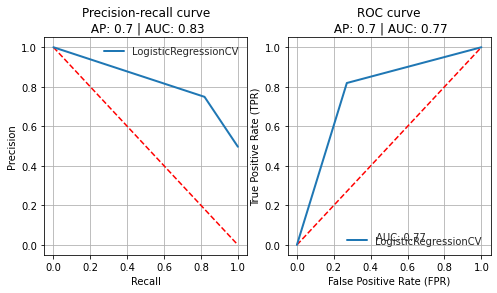

In [41]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
plot_pr(y_test, y_pred, ax=ax[0],label="LogisticRegressionCV")
plot_roc(y_test, y_pred, ax=ax[1],label="LogisticRegressionCV");

In [42]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

0.8508106977751556

0.7739130434782608
[[379 142]
 [ 92 422]]


,precision,recall,f1-score,support
0,0.804671,0.727447,0.764113,521.000000
1,0.748227,0.821012,0.782931,514.000000
accuracy,0.773913,0.773913,0.773913,0.773913
macro avg,0.776449,0.774229,0.773522,1035.000000
weighted avg,0.776640,0.773913,0.773458,1035.000000


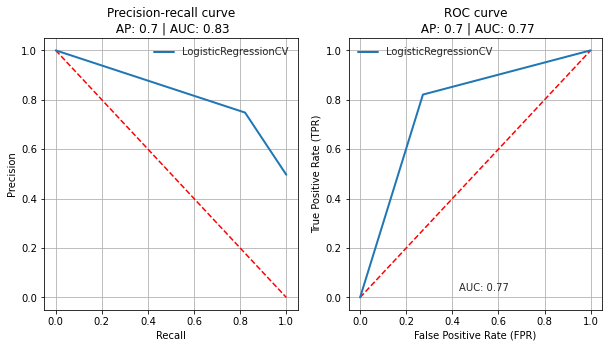

In [43]:
lrcv = LogisticRegressionCV(
    Cs=[0.1,1,10], penalty='l2', tol=1e-10, scoring='neg_log_loss', cv=5,
    solver='liblinear', n_jobs=4, verbose=0, refit=True,
    max_iter=100,
).fit(X_train, y_train)
y_pred = lrcv.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="LogisticRegressionCV")
plot_roc(y_test, y_pred, ax=axs[1], label="LogisticRegressionCV")

## Decision tree


In [44]:
params = {
"criterion":["gini", "entropy"],
"max_depth":[2,4,8,16],
"min_samples_split":[2,4,8, 16],
"min_samples_leaf":[2,4,6]}
clf = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

0.9525394609685386
0.8589371980676328
[[424  97]
 [ 49 465]]


,precision,recall,f1-score,support
0,0.896406,0.813820,0.853119,521.000000
1,0.827402,0.904669,0.864312,514.000000
accuracy,0.858937,0.858937,0.858937,0.858937
macro avg,0.861904,0.859244,0.858715,1035.000000
weighted avg,0.862137,0.858937,0.858678,1035.000000


In [45]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.9079871094946115

0.9524320841833995
0.8560386473429952
[[422  99]
 [ 50 464]]


,precision,recall,f1-score,support
0,0.894068,0.809981,0.849950,521.000000
1,0.824156,0.902724,0.861653,514.000000
accuracy,0.856039,0.856039,0.856039,0.856039
macro avg,0.859112,0.856352,0.855801,1035.000000
weighted avg,0.859348,0.856039,0.855762,1035.000000


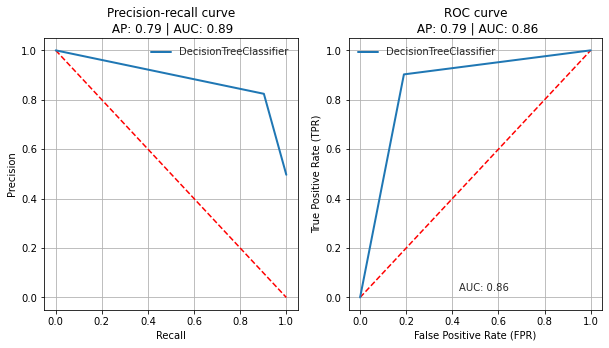

In [46]:
dt = DecisionTreeClassifier(**clf.best_params_).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(dt.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="DecisionTreeClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="DecisionTreeClassifier")

In [50]:
categories

['DeviceProtection',
 'Type_One year',
 'StreamingTV',
 'PaperlessBilling',
 'OnlineBackup',
 'gender',
 'Dependents',
 'OnlineSecurity',
 'PaymentMethod_Mailed check',
 'MultipleLines',
 'Partner',
 'Type_Two year',
 'StreamingMovies',
 'PaymentMethod_Credit card (automatic)',
 'TechSupport',
 'SeniorCitizen',
 'InternetService_Fiber optic',
 'PaymentMethod_Electronic check',
 'InternetService_No Service']

## Catboost (gradient boosting model)

In [47]:
X_train, X_test, y_train, y_test, features, target, categories = get_data(apply_dummies=True)

In [ ]:
train_ds = Pool(data=X_train, label=y_train, cat_features=categories, feature_names=features)
test_ds = Pool(data=X_test, label=y_test, cat_features=categories, feature_names=features)
full_ds = Pool(data=pd.concat([X_train, X_test], axis=0), label=pd.concat([y_train, y_test], axis=0), cat_features=categories, feature_names=features)

In [ ]:
cb = CatBoostClassifier(verbose=0,task_type="GPU", 
                        devices='0:1', random_seed=random_state).fit(train_ds)

In [ ]:
df_feature_importances = pd.DataFrame(((zip(cb.feature_names_, cb.get_feature_importance())))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"]);

In [ ]:
y_pred = cb.predict(test_ds)
print(cb.score(train_ds))

In [ ]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="CatBoostClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="CatBoostClassifier");

In [ ]:
param_grid = {
        'learning_rate': [0.1, 0.3],
        'depth': [10, 20, 40],
        'l2_leaf_reg': [3, 5, 7, 9],
        'iterations':[20, 60],
        'thread_count':[12],
        'border_count':[128]
}

model = CatBoostClassifier(loss_function='Logloss',eval_metric='AUC', task_type="GPU", devices='0:1', random_seed=random_state)
grid_search_result = model.grid_search(param_grid, 
                                       full_ds,
                                       verbose=0,
                                       partition_random_seed=random_state,
                                       search_by_train_test_split=True,
                                       train_size=0.9,
                                       plot=False)

In [ ]:
cv_data = pd.DataFrame(grid_search_result["cv_results"])
best_value = cv_data['test-AUC-mean'].max()
best_iter = cv_data['test-AUC-mean'].values.argmax()

print('Best validation test-AUC-mean : {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-AUC-std'][best_iter],
    best_iter)
)

In [ ]:
model = CatBoostClassifier(loss_function='Logloss', task_type="GPU", devices='0:1', random_seed=random_state, **grid_search_result["params"])
model.fit(train_ds, verbose = 0, eval_set = [(X_test, y_test)], use_best_model=True)
y_pred = model.predict(test_ds)
print("accuracy_score", accuracy_score(y_test, y_pred))
for i in [10, 15, 20]:
  print("roc_auc_score", roc_auc_score(y_test, model.predict_proba(test_ds, ntree_start=0, ntree_end=i)[:,1]))
print("f1_score", f1_score(y_test, y_pred))

let's search by "greedy" way

In [ ]:
from sortedcontainers import SortedList

class paramsearch:
    def __init__(self,pdict):    
        self.pdict = {}
        # if something is not passed in as a sequence, make it a sequence with 1 element
        #   don't treat strings as sequences
        for a,b in pdict.items():
            if isinstance(b, collections.Sequence) and not isinstance(b, str): self.pdict[a] = b
            else: self.pdict[a] = [b]
        # our results are a sorted list, so the best score is always the final element
        self.results = SortedList()       
                    
    def grid_search(self,keys=None):
        # do grid search on only the keys listed. If none provided, do all
        if keys==None: keylist = self.pdict.keys()
        else: keylist = keys
 
        listoflists = [] # this will be list of lists of key,value pairs
        for key in keylist: listoflists.append([(key,i) for i in self.pdict[key]])
        for p in product(*listoflists):
            # do any changes to the current best parameter set
            if len(self.results)>0: template = self.results[-1][1]
            else: template = {a:b[0] for a,b in self.pdict.items()}
            # if our updates are the same as current best, don't bother
            if self.equaldict(dict(p),template): continue
            # take the current best and update just the ones to change
            yield self.overwritedict(dict(p),template)
                              
    def equaldict(self,a,b):
        for key in a.keys(): 
            if a[key] != b[key]: return False
        return True            
                              
    def overwritedict(self,new,old):
        old = copy.deepcopy(old)
        for key in new.keys(): old[key] = new[key]
        return old            
    
    # save a (score,params) pair to results. Since 'results' is a sorted list,
    #   the best score is always the final element. A small amount of noise is added
    #   because sorted lists don't like it when two scores are exactly the same    
    def register_result(self,result,params):
        self.results.add((result+np.random.randn()*1e-10,params))    
        
    def bestscore(self):
        return self.results[-1][0]
        
    def bestparam(self):
        return self.results[-1][1]
        

In [ ]:
import catboost as cb
import collections
from itertools import product,chain
import copy

train_set = X_train
test_set = X_test


colnames = features
category_cols = categories
cat_dims = [train_set.columns.get_loc(i) for i in category_cols[:-1]] 

train_label = y_train.values
test_label = y_test.values

params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'thread_count':4,
          'loss_function':"Logloss"}

# this function does 3-fold crossvalidation with catboostclassifier          
def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]
        
        labels = train_label[train_index]
        test_labels = train_label[test_index]

        train_ds = Pool(data=train, label=labels, cat_features=categories, feature_names=features)
        test_ds = Pool(data=test, label=test_labels, cat_features=categories, feature_names=features)

        scale_pos_weight=(labels==0).sum()/(labels==1).sum()
        clf = CatBoostClassifier(**params, verbose=0, scale_pos_weight=scale_pos_weight)
        clf.fit(train_ds)
        res.append(np.mean(roc_auc_score(test_labels, clf.predict_proba(test_ds)[:,1])))
        # res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)
  
# this function runs grid search on several parameters
def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    max_metric = 0
    best_param = {}
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        if max_metric<res: 
          max_metric = res
          best_param = prms
        print(res,prms,'best:',ps.bestscore(),ps.bestparam())
    # return ps.bestparam()
    return best_param

bestparams = catboost_param_tune(params,train_set,train_label,cat_dims)

In [ ]:
clf = CatBoostClassifier(**bestparams, verbose=0)
clf.fit(train_ds)
roc_auc_score(y_test, clf.predict_proba(test_ds)[:,1])

In [ ]:
bestparams

# Summary

<div class="base-markdown base-markdown_with-gallery markdown markdown_size_normal markdown_type_theory"><h1>Solution Report</h1><div class="paragraph">Make a report at the end of the <em>Jupyter Notebook</em> with the solution. The team leader will check it. The code will be reviewed by the team leader only if there are some points of doubt.</div><div class="paragraph">In the report, please answer the following questions:</div><ul><li>What steps of the plan were performed and what steps were skipped (explain why)?</li><li>What difficulties did you encounter and how did you manage to solve them?</li><li>What were some of the key steps to solving the task?</li><li>What is your final model and what quality score does it have?</li></ul><div class="paragraph">Here are some of the criteria used by the team leader:</div><ul><li>Did you answer all the questions?</li><li>Are the answers clear?</li></ul></div>


We created a model for a churn prediction, did data transformation, preprocessing, analyzing features . Found out that recent clients have tendency to churn (maybe there are some external factors on the market)
Using new feature - days, we prove it, impact this feature on the model is strong
Then we build several models: Linear, Tree-based, and Gradient boosting based
and found best metric = 98%
Churn is related also with internet service type and type of the payment 

| model         | AUC score test |
| ------------- | -------------- |
| LR            | 84.00%         |
| Decision Tree | 90.00%         |
| GB (catboost) | 98.00%         |

<div class="alert alert-success">
    The modelling section is excellent! You tried a few models and did some very thorough hyperparameter tuning with correct cross-validation. Code quality is very good. It's great that you dealt with class imbalance by using oversampling and appropriately encoded categorical variables. Although a ROC-AUC of 0.98 is extremely suspicious (you don't usually get that kind of results in real life), I couldn't find any target leakage.
</div>

> agree about 0.98. but it was found by searching optimal parameters specifically on ROC-AUC score. also, think for business it could be interesting split clients by the group and treat them differently and try to find empirical risk in this case. Like VIP clients, regular one and new clients

<div class="alert alert-success">
    <b>Anton's comments: </b> Indeed, your model is very cool. Good job here!
</div>